# Going modular

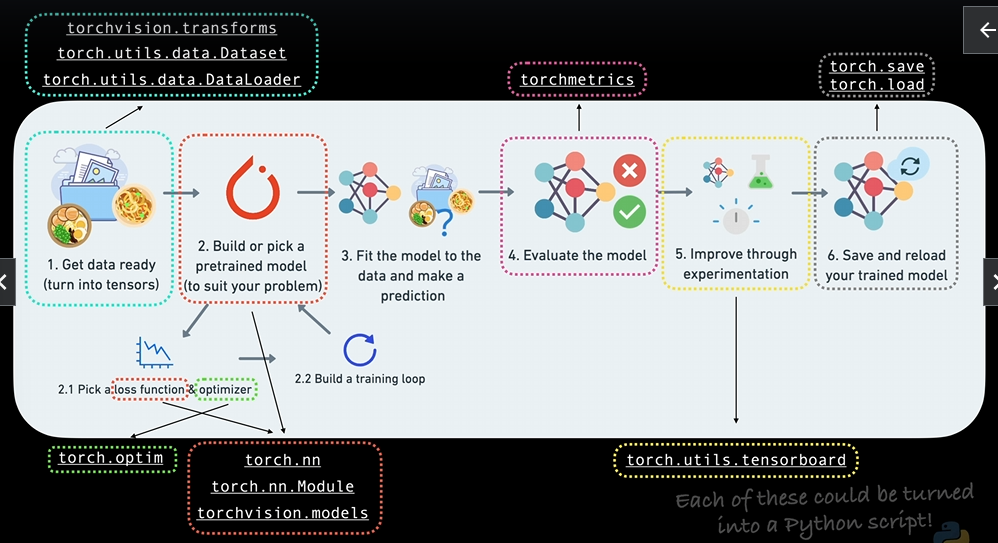

In [1]:
import os
os.makedirs("going_modular", exist_ok=True)

# 1. Get data

In [2]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...") 
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exists.
Unzipping pizza, steak, sushi data...


In [3]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

# 2. Create Datasets and DataLoaders

In [4]:
from torchvision import datasets, transforms

# Create simple transform
data_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [5]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=0, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x18c6b0d8f80>,
 <torch.utils.data.dataloader.DataLoader at 0x18c6b29da30>)

In [6]:
# Check out single image size/shape
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 2.1 Create Datasets and DataLoaders (script mode)

Rather than rewriting all of the code above everytime we wanted to load data, we can turn it into a script called data_setup.py.

Let's capture all of the above functionality into a function called create_dataloaders().

In [7]:
%%writefile going_modular/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for 
image classification data.
"""
import os

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

NUM_WORKERS = 0

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

Overwriting going_modular/data_setup.py


In [8]:
from going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, 
    test_dir=test_dir, 
    transform=data_transform, 
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x18c798e8770>,
 ['pizza', 'steak', 'sushi'])

# 3. Making a model (TinyVGG)

We're going to use the same model we used in notebook 04: TinyVGG from the CNN Explainer website.

The only change here from notebook 04 is that a docstring has been added using Google's Style Guide for Python.

In [9]:
import torch
from torch import nn 

class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture.

    Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
    See the original architecture here: https://poloclub.github.io/cnn-explainer/

    Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape, 
                    out_channels=hidden_units, 
                    kernel_size=3, 
                    stride=1, 
                    padding=0),  
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units, 
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from? 
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
        # return self.classifier(self.block_2(self.block_1(x))) # <- leverage the benefits of operator fusion

Now let's create an instance of TinyVGG and put it on the target device.

In [10]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate an instance of the model
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [11]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0208, -0.0020,  0.0095]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3371, 0.3295, 0.3333]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
0


## 3.1 Making a model (TinyVGG) (scriptmode)

Over the past few notebooks (notebook 03 and notebook 04), we've built the TinyVGG model a few times.

So it makes sense to put the model into its file so we can reuse it again and again.

Let's put our `TinyVGG()` model class into a script called `model_builder.py` with the line `%%writefile going_modular/model_builder.py`.

In [12]:
%%writefile going_modular/model_builder.py
"""
Contains PyTorch model code to instantiate a TinyVGG model.
"""
import torch

from torch import nn

class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture.

    Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
    See the original architecture here: https://poloclub.github.io/cnn-explainer/

    Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape, 
                    out_channels=hidden_units, 
                    kernel_size=3, 
                    stride=1, 
                    padding=0),  
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units, 
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from? 
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
        # return self.classifier(self.block_2(self.block_1(x))) # <- leverage the benefits of operator fusion



Overwriting going_modular/model_builder.py


In [13]:
import torch

from going_modular import model_builder

device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate an instance of the model from the "model_builder.py" script
torch.manual_seed(42)
model_1 = model_builder.TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                                hidden_units=10, 
                                output_shape=len(class_names)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Dummy forward pass

In [14]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_1.eval()
with torch.inference_mode():
    pred = model_1(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0208, -0.0020,  0.0095]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3371, 0.3295, 0.3333]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
0


# 4. Creating `train_step()` and `test_step()` functions and `train()`to combine them

Rather than writing them again, we can reuse the `train_step()` and `test_step()` functions from notebook 04.

The same goes for the `train()` function we created.

The only difference here is that these functions have had docstrings added to them in Google's Python Functions and Methods Style Guide.

Let's start by making `train_step()`.

In [15]:
from typing import Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [16]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

Combine them to `train()`

In [17]:
from typing import Dict, List

from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

## 4.1 Creating `train_step()` and `test_step()` functions and `train()` to combine them (script mode)

To create a script for `train_step()`, `test_step()` and `train()`, we'll combine their code all into a single cell.

We'll then write that cell to a file called `engine.py` because these functions will be the "engine" of our training pipeline.

We can do so with the magic line `%%writefile going_modular/engine.py`.

We'll also make sure to put all the imports we need (torch, typing, and tqdm) at the top of the cell.

In [18]:
%%writefile going_modular/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
from typing import Dict, List, Tuple

import torch

from tqdm.auto import tqdm

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

Overwriting going_modular/engine.py


# 5. Creating a function to save the model

In [19]:
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

## 5.1 Creating a function to save the model (script mode)

How about we add our `save_model()` function to a script called `utils.py` which is short for "utilities".

We can do so with the magic line `%%writefile going_modular/utils.py`.

In [20]:
%%writefile going_modular/utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
from pathlib import Path

import torch

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

Overwriting going_modular/utils.py


# 6. Train, evaluate and save the model

In [21]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

# Save the model
save_model(model=model_0,
           target_dir="models",
           model_name="05_going_modular_cell_mode_tinyvgg_model.pth")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3011
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0868 | train_acc: 0.4883 | test_loss: 1.0806 | test_acc: 0.5028
Epoch: 4 | train_loss: 1.0843 | train_acc: 0.4023 | test_loss: 1.0609 | test_acc: 0.5833
Epoch: 5 | train_loss: 1.0663 | train_acc: 0.4102 | test_loss: 1.0655 | test_acc: 0.5644
[INFO] Total training time: 8.233 seconds
[INFO] Saving model to: models\05_going_modular_cell_mode_tinyvgg_model.pth


## 6.2 Train, evaluate and save the model (script mode)

Let's combine all of our modular files into a single script `train.py`.

This will allow us to run all of the functions we've written with a single line of code on the command line:

`python going_modular/train.py`

Or if we're running it in a notebook:

`!python going_modular/train.py`

We'll go through the following steps:

1. Import the various dependencies, namely torch, os, torchvision.transforms and all of the scripts from the going_modular directory, data_setup, engine, model_builder, utils.

Note: Since `train.py` will be inside the going_modular directory, we can import the other modules via import ... rather than from going_modular import ....

2. Setup various hyperparameters such as batch size, number of epochs, learning rate and number of hidden units (these could be set in the future via Python's argparse).
3. Setup the training and test directories.
4. Setup device-agnostic code.
5. Create the necessary data transforms.
6. Create the DataLoaders using data_setup.py.
7. Create the model using model_builder.py.
8. Setup the loss function and optimizer.
9. Train the model using engine.py.
10. Save the model using utils.py.


In [22]:
%%writefile going_modular/train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""


import os
import torch
from torchvision import transforms
import data_setup, engine, model_builder, utils


# Setup hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

# Setup directories
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
data_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create DataLoaders with help from data_setup.py
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)

# Create model with help from model_builder.py
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
).to(device)

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

# Save the model with help from utils.py
utils.save_model(model=model,
                 target_dir="models",
                 model_name="05_going_modular_script_mode_tinyvgg_model.pth")


Overwriting going_modular/train.py


In [23]:
!python going_modular/train.py

Epoch: 1 | train_loss: 1.1039 | train_acc: 0.2852 | test_loss: 1.1099 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.1018 | train_acc: 0.3203 | test_loss: 1.1244 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0980 | train_acc: 0.3047 | test_loss: 1.1306 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0935 | train_acc: 0.4258 | test_loss: 1.1323 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0939 | train_acc: 0.3047 | test_loss: 1.1372 | test_acc: 0.2604
[INFO] Saving model to: models\05_going_modular_script_mode_tinyvgg_model.pth



100%|██████████| 5/5 [00:05<00:00,  1.05s/it]
